In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 #no. of samples that feed into model at each iteration of the training process
CHANNELS = 3 #rgb
EPOCHS = 50 #no. of complete passes of the training set through the algo.

## Load data into tf.dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

* 'Potato___Early_blight' = 0
* 'Potato___Late_blight' = 1
* 'Potato___healthy' = 2

In [5]:
len(dataset) #this gives 68 because data are stored in batches 2152/32

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 1 0 1 0 0 0 0 2 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[111. 100. 106.]
  [ 91.  80.  86.]
  [ 98.  87.  93.]
  ...
  [146. 137. 142.]
  [146. 137. 142.]
  [146. 137. 142.]]

 [[104.  93.  99.]
  [ 96.  85.  91.]
  [ 98.  87.  93.]
  ...
  [142. 133. 138.]
  [143. 134. 139.]
  [144. 135. 140.]]

 [[102.  91.  97.]
  [103.  92.  98.]
  [102.  91.  97.]
  ...
  [139. 130. 135.]
  [141. 132. 137.]
  [142. 133. 138.]]

 ...

 [[104.  94. 103.]
  [101.  91. 100.]
  [ 98.  88.  97.]
  ...
  [129. 123. 135.]
  [134. 128. 140.]
  [126. 120. 132.]]

 [[103.  93. 102.]
  [104.  94. 103.]
  [104.  94. 103.]
  ...
  [130. 124. 136.]
  [126. 120. 132.]
  [125. 119. 131.]]

 [[ 99.  89.  98.]
  [101.  91. 100.]
  [103.  93. 102.]
  ...
  [137. 131. 143.]
  [130. 124. 136.]
  [133. 127. 139.]]]


## Data visualization

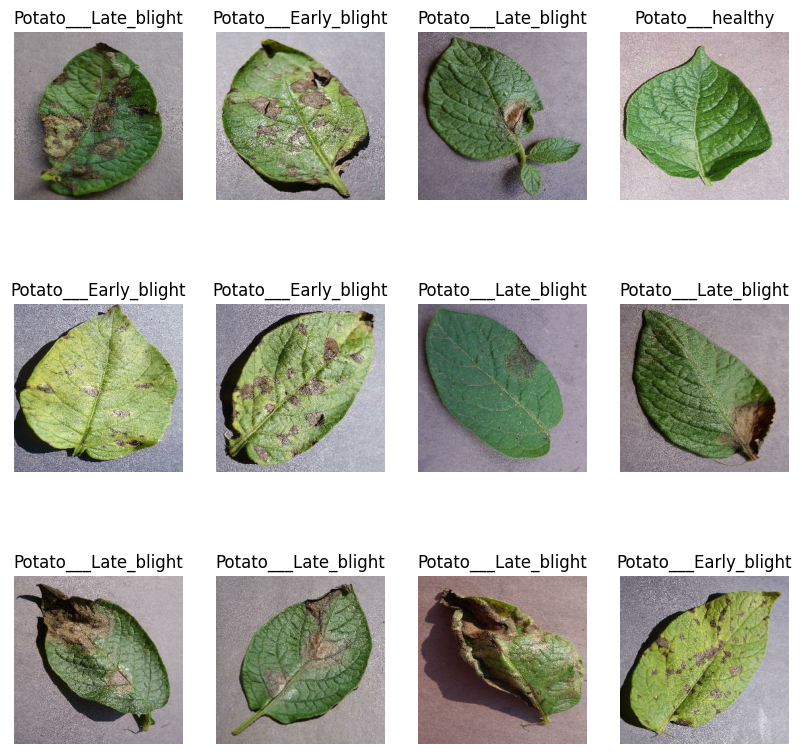

In [8]:
plt.figure(figsize=(10,10)) #figure size
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1) #matrix of images
        #have to convert float->int
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.axis("off") #remove axis
        plt.title(class_names[label_batch[i]]) #display which class it belongs

## Spliting the dataset
* Training -> 80%
* Validation -> 10% (Done after each Epoch)
* Test -> 10% (Done after model is completed)

In [9]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

train_ds = dataset.take(round(len(dataset)*train_size)) #take 54
remain_ds = dataset.skip(round(len(dataset)*train_size)) #skip 54 and take remaining 14
val_ds = remain_ds.take(round(len(dataset)*val_size)) #take 7
test_ds = remain_ds.skip(round(len(dataset)*val_size)) #skip 7 take remaining 4

In [10]:
len(val_ds)

7

In [11]:
len(dataset)

68

In [12]:
#function to split
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #to reproduce results

    train_size = int(round(train_split*ds_size))
    print(train_size)
    val_size = int(round(val_split*ds_size))
    print(val_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

54
7


In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

7

In [16]:
len(test_ds)

7

In [17]:
#cache a dataset, either in memory or on local storage
#prefetch will optimize by using cpu to prefetch next batch while gpu is training the current batch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data preprocessing
* Here resize and rescale done even though all the images from dataset is same, once predictions starts, user may enter different sizes

In [18]:
resize_with_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255) #normalizing  the image pixel value ranged between 0 and 1
])

### Data augmentation
* Using synthetic data, so the trained model will be more accurate for any type of (rotated, flipped, etc) image added by user.
* Creates new variations of the images to help the model learn better.
    * layers.RandomFlip("horizontal_and_vertical") - Randomly flips images horizontally or vertically
    * layers.RandomRotation(0.2) - Randomly rotates images by up to 20%

In [19]:
#generating synthetic data from original dataset
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

### Model Building

#### Conv2D convolution layer

1. Purpose
   * Conv2D layer automatically and adaptively learn spatial hierarchies of features from input images.
   * It identify patterns such as edges, textures, and shapes that are crucial for understanding the content of the images.

2. How it works
   * Filters/Kernels
     * Use small square matrices (e.g. - 3x3) that slide over the input image.
     * Each filter detect specific features in the image, such as vertical or horizontal edges.
   * Convolution Operation
     * As the filter moves across the image, it performs a mathematical operation called convolution.
     * The convolution operation involves multiplying the filter values with the overlapping pixel values of the image and summing the results to produce a single value in the output feature map.
   * Feature Maps
     * The result of applying a filter across the image is called a feature map.
     * Each feature map highlights the presence of a particular feature (e.g., an edge or texture) in different parts of the image.
   * Activation Function
     * After the convolution operation, an activation function (e.g., ReLU) is applied to introduce non-linearity into the model.
     * This helps the network learn more complex patterns.

3. Parameters
   * No. of filters (32) - The number of filters determines the number of feature maps produced by the layer. More filters allow the model to learn more features but increase computational cost.
   * kernel_size (3,3) - int or tuple/list of 2 integer, specifying the size of the convolution window
   * Filter Size (3x3) - The size of the filter determines the size of the region in the input image that the filter looks at during the convolution operation.
   * Stride - Stride determines how much the filter moves at each step. A stride of 1 means the filter moves one pixel at a time.
   * Padding - Padding is used to control the spatial dimensions of the output feature map. With padding, the model can retain the spatial dimensions of the input image.
   * Activation (relu) - Applies the activation function.
   * Input shape - Specifies the shape of the input data
  
#### MaxPooling2D pooling layer

1. Purpose
   * Downsampling
     * The primary purpose of the MaxPooling2D layer is to reduce the spatial dimensions (width and height) of the input feature maps. This is known as downsampling.
     * It helps to decrease the computational load and the number of parameters, which can mitigate overfitting.
   * Feature Extraction
     * By reducing the dimensions, the layer retains the most important features detected by the convolutional layers while discarding less significant information.
     * This makes the model more efficient and focused on key patterns.

2. How it works
   * Pooling Operation
     * The MaxPooling2D layer operates on small, non-overlapping regions (e.g. - 2x2) of the input feature map.
     * For each region, it selects the maximum value. This operation effectively summarizes the presence of a feature in that region by its most prominent activation.
   * Stride
     * Stride determines how much the pooling window moves at each step.
     * A stride equal to the pooling size (e.g. - 2 for a 2x2 window) ensures non-overlapping regions.

3. Parameters
   * Pool size (2x2) - Specifies the dimensions of the pooling windows
   * Stride - Often, the stride is equal to the pool size. This means that the pooling window moves by 2 pixels (for a 2x2 pool size) at a time.

### Stacking layers

1. Deciding the number of layers is done by considering following factors.
   * Complexity of the task
   * Amount of data
   * Computational resources
   * Model performance
     * Experimentation and cross-validation are key.
     * Start with a basic architecture and gradually increase the number of layers while monitoring performance on a validation set.
   * Transfer Learning
     * Using pre-trained models allows to leverage architectures designed by experts and fine-tune them for a specific task.
    
2. Stacking layers allow to accomplish following things.
   Stacking layers in a neural network allows the model to learn increasingly abstract and complex representations of the input data.
   * Initial layers
     * The first few layers in a CNN typically detect simple patterns such as edges, corners, and textures.
     * These are called low-level features.
   * Intermediate Layers
     * By adding more layers, the network starts to combine the low-level features to detect more complex patterns, such as shapes and object parts (e.g., wheels of a car, eyes on a face).
   * Deeper Layers
     * In the deepest layers, the network can recognize high-level features and entire objects.
     * It integrates the information from previous layers to form a comprehensive understanding of the image.
   * Fully Connected Layers
     * After several convolutional and pooling layers, the final layers are usually fully connected layers that make predictions based on the learned features.
    
#### How to stack layers in practice

1. Begin with a few convolutional layers (e.g., 2-3) followed by pooling layers.
2. Add more convolutional layers to increase the model's capacity to learn complex patterns.
3. Monitor Performance
   * Use validation accuracy/loss to decide if adding more layers improves performance.
   * If the model starts to overfit (validation performance worsens), consider reducing the number of layers or using regularization techniques.
4. Use Pre-Trained Models
   * For very complex tasks, start with a pre-trained model and fine-tune it for a specific dataset.
  
### Flatten layer

* Converts the 2D feature maps into a 1D array

### Dense layers

* Typically used towards the end of the network, especially in Convolutional Neural Networks.
* Crucial for interpreting the features extracted by the convolutional and pooling layers and making the final classification.

#### First dense layer

1. Feature Interpretation:
   * The first Dense layer processes the flattened output from the previous layers (usually convolutional or pooling layers) and learns to interpret the features.
   * It helps the network to start combining the features into more complex representations.

2. Non-Linearity Introduction:
   * This layer typically uses an activation function like ReLU (Rectified Linear Unit) to introduce non-linearity, enabling the network to learn complex patterns.

3. Neurons:
   * The number of neurons in this layer can vary. A higher number of neurons allows the network to learn more complex representations but also increases the computational load and the risk of overfitting.

Example: layers.Dense(64, activation='relu') means the layer has 64 neurons and uses the ReLU activation function.

#### Second dense layer

1. Output Layer:
   * The second Dense layer often serves as the output layer, especially in classification tasks.
   * This layer transforms the learned features into the final output predictions.

2. Number of Neurons:
   * The number of neurons in the output Dense layer typically corresponds to the number of classes in the classification task.

3. Activation Function:
   * The activation function used in this layer is usually softmax for multi-class classification problems.
   * Softmax converts the raw output scores into probabilities that sum to 100%, making it easier to interpret the predictions.

Example: layers.Dense(n_classes, activation='softmax') means the layer has n_classes neurons and uses the softmax activation function to output class probabilities.


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 #no. of categories

model = models.Sequential([
    #resize and rescale layer
    resize_with_rescale,
    
    #data augmentation layer
    data_augmentation,
    
    #convolutional layer
    #identify various features
    #layers.Conv2D(no. filters/layers, filter size, activation layer, input shape=255x255)
    #relu is the most used activation for hidden layers because it is very fast to compute
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),

    #pooling layer
    #chose most(max value of each feature map) important features
    layers.MaxPooling2D((2, 2)),

    #stacking layers - have to check again
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #convert 2D feature maps into a 1D array
    #flatten into array of neuron
    layers.Flatten(),

    #dense layer of 64 neurons
    layers.Dense(64, activation='relu'),

    #last layer of 3 neurons with softmax - normalize the probability of classes
    layers.Dense(n_classes, activation='softmax')
])

#builds the model with the specified input shape
model.build(input_shape=input_shape)

### Just getting a summary of the model

* param = weights

In [24]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Model compilation
* Use optimizer such as 'adam'
* Define loss function
* Then accuracy will be used as the metric to track the training process

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training the network
* x = train_ds - Input data
* epochs - Number of epochs to train the model
    * Epoch refers to one complete pass of the training dataset through the algorithm.
* batch_size - Number of samples per gradient update (default=32)
* verbose - 
    * verbose=0 will show nothing (silent)
    * verbose=1 will show an animated progress bar.
    * verbose=2 will just mention the number of epoch.
* validatation_data - Data on which to evaluate the loss and any model metrics at the end of each epoch.

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4238 - loss: 0.9713 - val_accuracy: 0.4286 - val_loss: 0.8843
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5813 - loss: 0.8014 - val_accuracy: 0.7188 - val_loss: 0.6354
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7739 - loss: 0.5322 - val_accuracy: 0.8348 - val_loss: 0.4112
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8353 - loss: 0.3831 - val_accuracy: 0.9018 - val_loss: 0.2845
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8575 - loss: 0.3361 - val_accuracy: 0.8661 - val_loss: 0.3766
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8997 - loss: 0.2606 - val_accuracy: 0.9018 - val_loss: 0.3265
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9269 - loss: 0.2050 - val_accuracy: 0.9018 - val_loss: 0.2345
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9286 - loss: 0.1854 - val_accuracy: 0.9643 - val_loss:

KeyboardInterrupt: 

In [24]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.9615 - loss: 0.1240


[0.15647073090076447, 0.95703125]

## Plotting training vs validation accuracy

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

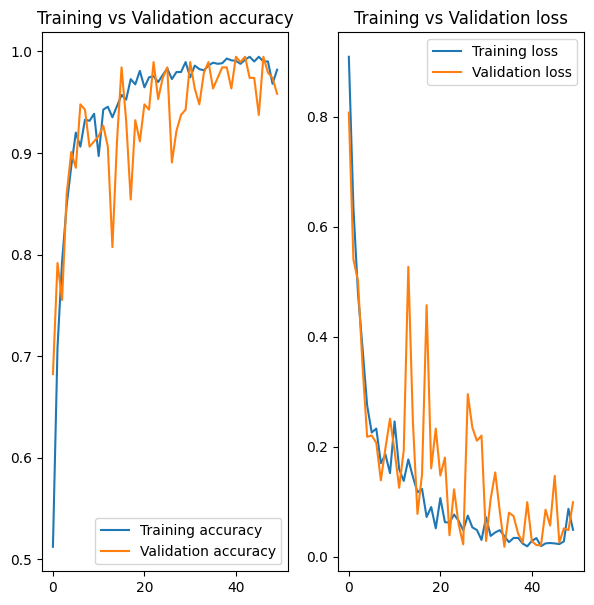

In [28]:
plt.figure(figsize=(7, 7))

#plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation accuracy')

#plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation loss')

plt.show()

In [ ]:
for images_batch, labels_batch in test_ds,take(1):
    first_img = images_batch